<a href="https://githubtocolab.com/Astolfo2332/HyM_prediction/blob/main/0.3_Modelos_iniciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Descarga de datos y su concatenación

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/HyM_prediction/main/data_set_1.csv
!wget https://raw.githubusercontent.com/Astolfo2332/HyM_prediction/main/data_set_2.csv
!wget https://raw.githubusercontent.com/Astolfo2332/HyM_prediction/main/data_set_3.csv
!wget https://raw.githubusercontent.com/Astolfo2332/HyM_prediction/main/data_set_4.cvs

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error,average_precision_score
import seaborn as sns

In [3]:
p1=pd.read_csv("data_set_1.csv")
p2=pd.read_csv("data_set_2.csv")
p3=pd.read_csv("data_set_3.csv")
p4=pd.read_csv("data_set_4.cvs")

In [4]:
dataset=pd.concat([p1,p2,p3,p4])

In [7]:
dataset

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_type_name,colour_group_name,index_group_name,section_name
0,389377,637549005,0.030492,1,1,0,2,33,97,6,2,44
1,390861,637549005,0.028797,1,1,0,2,59,97,6,2,44
2,394289,637549005,0.028797,0,0,0,1,25,97,6,2,44
3,394310,637549005,0.033881,0,0,0,1,36,97,6,2,44
4,394340,637549005,0.033881,0,0,0,1,34,97,6,2,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1324508,376781,637549005,0.033881,1,1,0,2,55,97,6,2,44
1324509,378852,637549005,0.030492,0,0,0,1,68,97,6,2,44
1324510,385993,637549005,0.033881,1,1,0,2,53,97,6,2,44
1324511,385993,637549005,0.033881,1,1,0,2,53,97,6,2,44


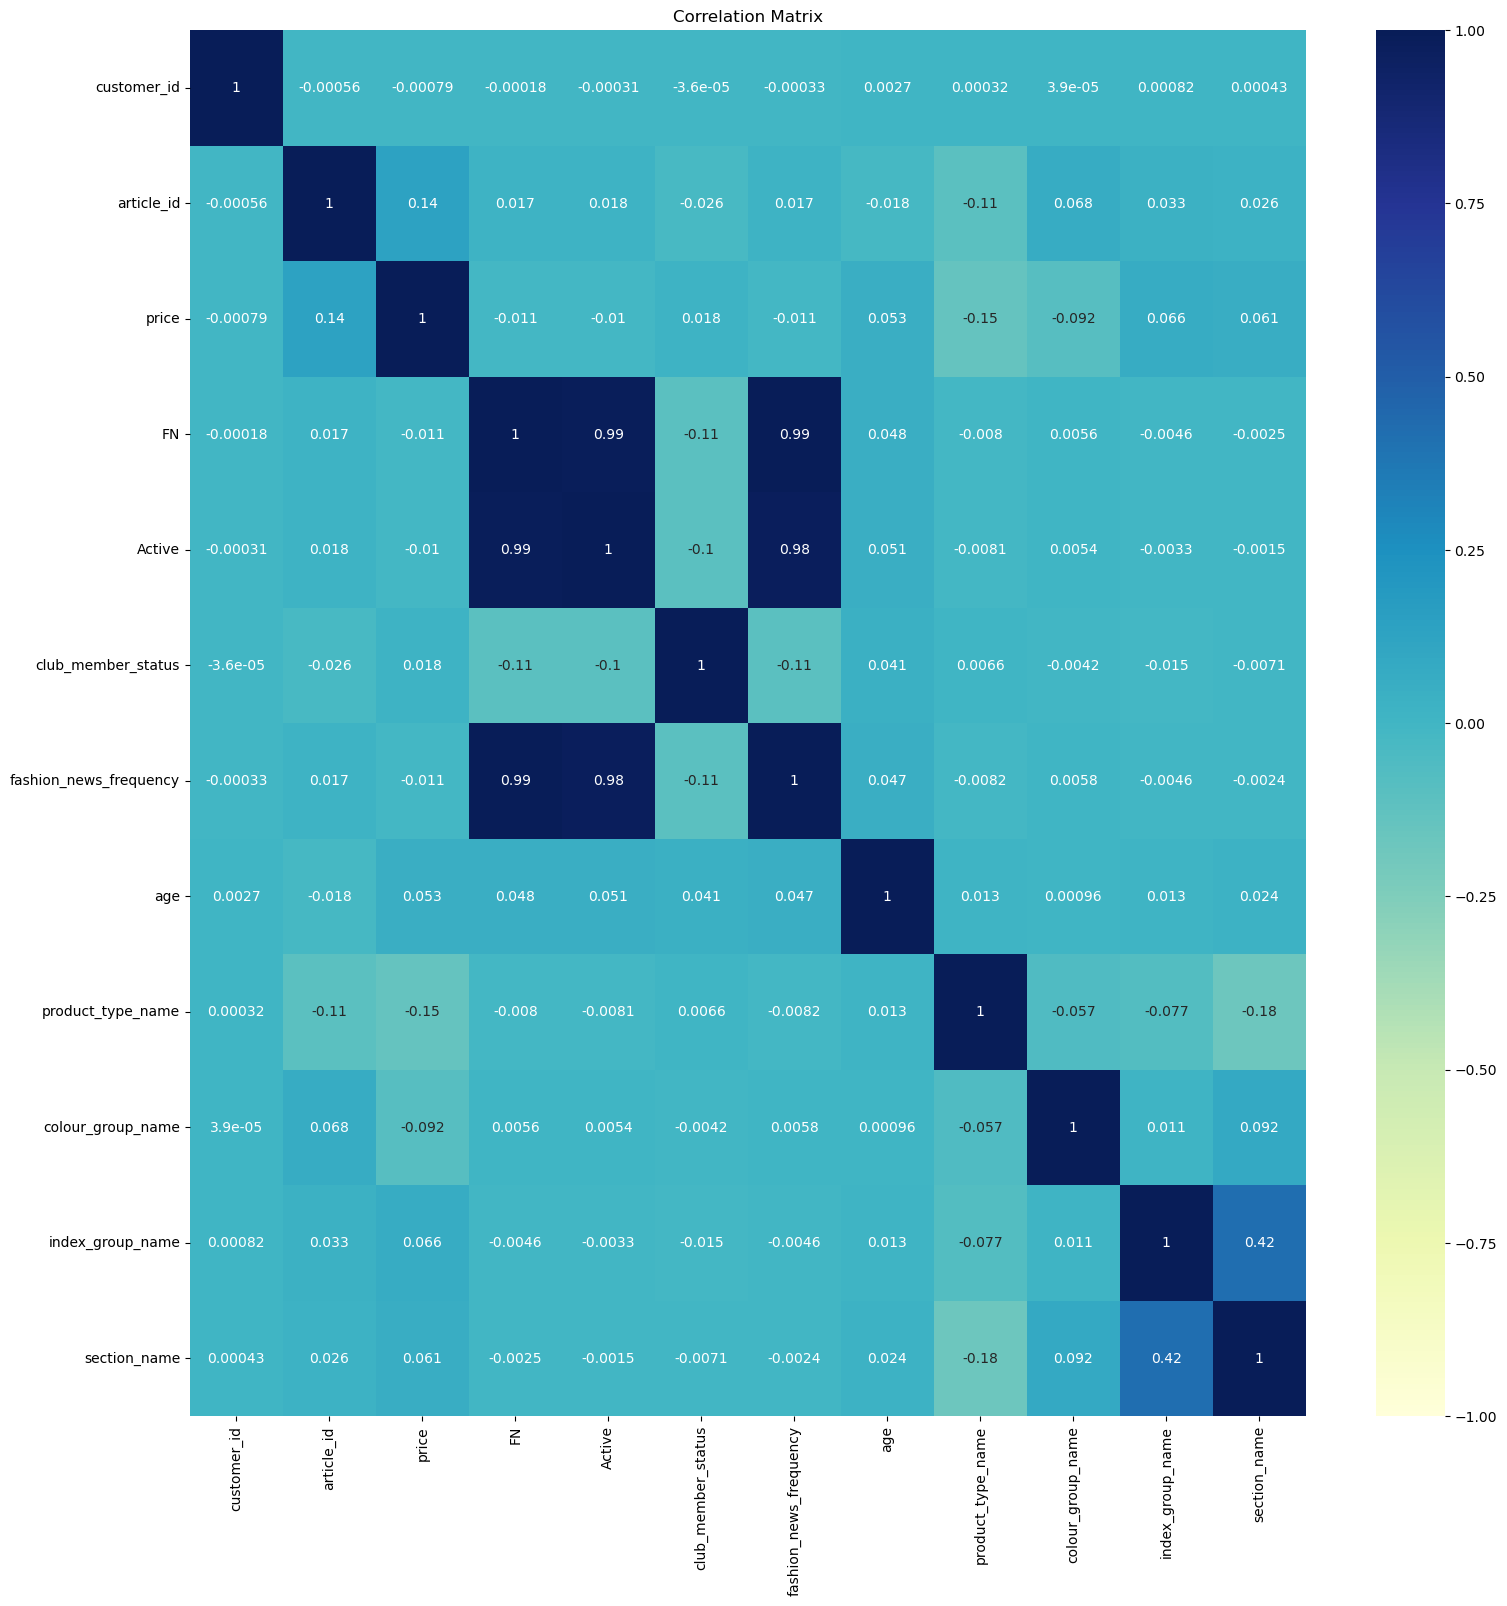

In [68]:
corr_matrix = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [69]:
target_corr_df = pd.DataFrame(corr_matrix["article_id"].sort_values(ascending=False))
target_corr_df 

,article_id
article_id,1.000000
price,0.137919
colour_group_name,0.068355
index_group_name,0.033342
section_name,0.025977
Active,0.017612
fashion_news_frequency,0.017491
FN,0.017050
customer_id,-0.000564
age,-0.018444


## 1. Métodos supervisados

Métrica

In [34]:
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("Map_12 Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("Map_12 Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [60]:
def map_12(y_actual, y_pred):
    map_12 = average_precision_score(y_actual, y_pred, average='macro')
    return map_12

In [10]:
x=dataset.drop(["article_id"],axis=1)
y=dataset["article_id"].values

In [35]:
from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(5298055, 11) (5298055,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(3708638, 11) (1589417, 11)


In [36]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [63]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
Map_12 Test:  129018818.58302 (± 64469.54214074 )
Map_12 Train:  129136105.83935 (± 48365.53413810 )
---------
Map_12 Test:  123009178.67572 (± 58287.78654524 )
Map_12 Train:  123007937.74878 (± 56686.27028798 )
---------
Map_12 Test:  122920353.89940 (± 73612.50476389 )
Map_12 Train:  122997344.54165 (± 53015.10948092 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
#Esta celda puede tomar un tiempo considerable en su ejecución
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [19]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=15)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 15}


In [20]:
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

DecisionTreeRegressor(max_depth=15)

In [23]:
print('Map_12 del Decision Tree en entrenamiento: ',"{:.5f}".format(map_12((ytv) , (Des_tree.predict(Xtv)))))
print('Map_12 del Decision Tree seleccionado: ',"{:.5f}".format(map_12(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  95886480.20773
RMSLE del Decision Tree seleccionado:  97676658.41003


In [24]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [25]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=10)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 10}


In [26]:
Rdm_forest = RandomForestRegressor(n_estimators = 9,max_depth = 10)
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=10, n_estimators=9)

In [30]:
print('Map_12 del Random Forest en entrenamiento: ',"{:.5f}".format(map_12((ytv) , (Rdm_forest.predict(Xtv)))))
print('Map_12 del Random Forest seleccionado: ',"{:.5f}".format(map_12(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  106705115.54519
RMSLE del Random Forest seleccionado:  106788289.26832


## PCA

In [32]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(map_12(yts , Rdm_forest.predict(Xts)))
    print('Map_12 del modelo con ', i ,'elementos: ',"{:.5f}".format(map_12(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor Map_12: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')
    

(3708638, 1) (1589417, 1)
RMSLE del modelo con  1 elementos:  129984918.10636
------------
(3708638, 3) (1589417, 3)
RMSLE del modelo con  3 elementos:  115085271.57838
------------
(3708638, 5) (1589417, 5)
RMSLE del modelo con  5 elementos:  115174100.63858
------------
(3708638, 7) (1589417, 7)
RMSLE del modelo con  7 elementos:  114195189.93940
------------
(3708638, 9) (1589417, 9)
RMSLE del modelo con  9 elementos:  114341334.89956
------------
Mejor RMSLE:  114195189.93940   ; obtenido con  7  componentes para PCA


In [39]:
#MEJOR PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(3708638, 5) (1589417, 5)


In [42]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [43]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 15}


In [44]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

(3708638, 5) (1589417, 5)


RandomForestRegressor(max_depth=9, n_estimators=15)

In [54]:
#Desempeño del modelo Random Forest seleccionado

print('Map_12 del Random Forest en entrenamiento: ',"{:.5f}".format(map_12((ytv) , (Rdm_forest.predict(Xtv)))))
print('Map_12 del Random Forest seleccionado: ',"{:.5f}".format(map_12(yts , Rdm_forest.predict(Xts))))

TypeError: average_precision_score() got an unexpected keyword argument 'max_samples'

# NMF

In [ ]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=15)
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(X2)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

In [ ]:
#MEJOR NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

In [ ]:
#Nota: esta celda requiere de gran tiempo para completarse
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

In [ ]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

In [ ]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

In [ ]:
print('Map_12 del Decision Tree en entrenamiento: ',"{:.5f}".format(map_12((ytv) , (Des_tree.predict(Xtv)))))
print('Map_12 del Decision Tree seleccionado: ',"{:.5f}".format(map_12(yts , Des_tree.predict(Xts))))

# Curvas

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

In [ ]:
Des_tree1 = DecisionTreeRegressor(max_depth=15)
train_sizes, train_scores, valid_scores = learning_curve(Des_tree1, Xtv, ytv, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

In [ ]:
train_mean

In [ ]:
valid_mean

In [ ]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Map_12"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

In [ ]:
X = train.drop(['meter_reading'],axis = 1)
y = train['meter_reading'].values

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(x)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=15)

In [ ]:
lc_plot(Des_tree,Xtv,ytv)